## **CSI4142 - A3: Part 1**

**Group:** 9

**Members:** 
- Jay Ghosh (300243766) 
- Alexander Azizi-Martin (300236257)

**Introduction**

This notebook illustrates a high-level workflow for preparing and modeling a dataset using linear regression. The process begins with basic data validation and duplicate removal. Categorical features are then one-hot encoded, and LOF is employed to numeric outliers. New features are engineered to capture aspects like depreciation and usage patterns. Several variants of the dataset were tested using linear regression, with cross-validation guiding the choice of final model.

### **Dataset Description**

**Dataset Name:** CAR DETAILS FROM CAR DEKHO [1]

**Dataset Author:** Nehal Birla, Nishant Verma, Nikhil Kushwaha [1]

**Purpose:** The dataset was built for a pedagogical purpose: to exemplify the use of linear regression in machine learning. [1]

In [585]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

In [586]:
# Loading dataset
df_path = kagglehub.dataset_download("nehalbirla/vehicle-dataset-from-cardekho")
df = pd.read_csv(f"{df_path}/CAR DETAILS FROM CAR DEKHO.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


**Dataset Shape**

In [587]:
df.shape

(4340, 8)

The dataset has 4340 rows and 8 columns.

**Features of the dataset (and what they mean)**

In [588]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


**Features:**

**name**:
- Type: Categorical
- Purpose: Represents the model or make of a car.

**year:**
- Type: Numerical
- Purpose: Year of manufacture of the car.

**selling_price**:
- Type: Numerical
- Purpose: Price at which the car is sold. **The target variable for regression.**

**km_driven**
- Type: Numerical
- Purpose: Kilometers driven by the vehicle, impacting its depreciation.

**fuel**
- Type: Categorical
- Purpose: Type of fuel used, e.g. petrol, diesel.

**seller_type**
- Type: Categorical
- Purpose: Indicates the type of seller, e.g. individual or dealer.

**transmission**
- Type: Categorical
- Purpose: Indicates vehicle transmission type, e.g. automatic or manual.

**owner**
- Type: Categorical
- Purpose: Number of previous owners, indicating vehicle usage and condition history.


### **Section A: Validating and Cleaning**

#### **Check 1: Data Type**

In [589]:
# Define columns with explicitly expected datatypes
expected_dtypes = {
    "year": "numeric",
    "selling_price": "numeric",
    "km_driven": "numeric",
    "name": "string",
    "fuel": "string",
    "seller_type": "string",
    "transmission": "string",
    "owner": "string"
}

# Checker Code
errors = {}
for col, expected_type in expected_dtypes.items():
  if expected_type == "numeric":
    parsed_col = pd.to_numeric(df[col], errors="coerce")
    failed_mask = parsed_col.isna() & df[col].notna()
  elif expected_type == "string":
    failed_mask = ~df[col].apply(lambda x: isinstance(x, str))
  errors[col] = df.loc[failed_mask]
  
# Results
for col, errors_df in errors.items():
  type_to_check = expected_dtypes[col]
  print(f"Report on Data Type Check for '{col}' ({type_to_check})")
  if errors_df.empty:
    print(f"No data type errors found in column '{col}'.")
  else:
    print(f"{len(errors_df)} rows have invalid {type_to_check} values in '{col}'.")
    print("Examples of invalid rows:")
    display(errors_df.head(10))

Report on Data Type Check for 'year' (numeric)
No data type errors found in column 'year'.
Report on Data Type Check for 'selling_price' (numeric)
No data type errors found in column 'selling_price'.
Report on Data Type Check for 'km_driven' (numeric)
No data type errors found in column 'km_driven'.
Report on Data Type Check for 'name' (string)
No data type errors found in column 'name'.
Report on Data Type Check for 'fuel' (string)
No data type errors found in column 'fuel'.
Report on Data Type Check for 'seller_type' (string)
No data type errors found in column 'seller_type'.
Report on Data Type Check for 'transmission' (string)
No data type errors found in column 'transmission'.
Report on Data Type Check for 'owner' (string)
No data type errors found in column 'owner'.


No data type errors, so no cleaning required here.

#### **Check 2: Range Check**

In [590]:
# Define ranges for numeric columns
ranges = {
    "year": (1900, 2025),
    "selling_price": (1, 1e7),
    "km_driven": (0, 1e6)
}

# Checker Code
range_errors = {}
for col, (min_val, max_val) in ranges.items():
    out_of_range_mask = (df[col] < min_val) | (df[col] > max_val)
    range_errors[col] = df.loc[out_of_range_mask]

# Results
for col, error_df in range_errors.items():
    print(f"Report on Range Check for '{col}' (Range: {ranges[col]})")
    if error_df.empty:
        print(f"No range errors found in column '{col}'.")
    else:
        print(f"{len(error_df)} range errors found in column '{col}'.")
        print("Examples of out-of-range rows:")
        display(error_df.head(10))

Report on Range Check for 'year' (Range: (1900, 2025))
No range errors found in column 'year'.
Report on Range Check for 'selling_price' (Range: (1, 10000000.0))
No range errors found in column 'selling_price'.
Report on Range Check for 'km_driven' (Range: (0, 1000000.0))
No range errors found in column 'km_driven'.


No range errors, so no cleaning required here.

#### **Check 3: Format Check**

In [591]:
# Define format rules as regex patterns for relevant columns
format_rules = {
    "year": r"^\d{4}$",  # 4 digits
}

# Checker Code
format_errors = {}
for col, pattern in format_rules.items():
    failed_mask = ~df[col].astype(str).str.match(pattern)
    format_errors[col] = df.loc[failed_mask]

# Results
for col, error_df in format_errors.items():
    print(f"Report on Format Check for '{col}' (Pattern: '{format_rules[col]}')")
    if error_df.empty:
        print(f"No format errors found in column '{col}'.")
    else:
        print(f"{len(error_df)} format errors found in column '{col}'.")
        print("Examples of format errors:")
        display(error_df.head(10))

Report on Format Check for 'year' (Pattern: '^\d{4}$')
No format errors found in column 'year'.


No format errors, so no cleaning required here.

#### **Check 4: Consistency Check**

While we do have columns like year, selling_price, km_driven, fuel, seller_type, transmission, and owner, there is no strict, guaranteed set of logical dependencies in this dataset. For example, it is not explicitly required that a specific fuel type must always imply a specific transmission value, nor that a particular owner status dictates a precise range for km_driven. Any rules we could create (for instance, "electric cars can’t be manual") tend to be heuristic rather than definitively contradictory. As such, pure consistency checks (strict logic rules that a violation would necessarily mean invalid data) do not meaningfully apply here.

#### **Check 5: Uniqueness Check** 

In our dataset, columns such as name, year, selling_price, km_driven, fuel, seller_type, transmission, and owner do not include any natural primary key (like a car_id or VIN) that must be uniquely assigned to each record. The combination of, for instance, name and year can recur legitimately for multiple cars of the same model and production year, and no domain rule explicitly states any field or set of fields must be unique across the dataset. Thus, a "uniqueness check" provides little value here, as repeated entries do not necessarily indicate invalid or duplicated data but can simply reflect different cars sharing attributes.

#### **Check 6: Presence Check** 

In [592]:
# Define which columns must not be null for presence checks
presence_cols = [
    "year",
    "selling_price",
    "km_driven",
    "name",
    "fuel",
    "seller_type",
    "transmission",
    "owner"
]

# Checker Code
presence_errors = {}
for col in presence_cols:
    missing_mask = df[col].isnull()
    presence_errors[col] = df.loc[missing_mask]

# Results
for col, error_df in presence_errors.items():
    print(f"Report on Presence Check for '{col}'")
    if error_df.empty:
        print(f"No missing values found in column '{col}'.")
    else:
        print(f"{len(error_df)} rows have missing (null) values in '{col}'.")
        print("Examples of missing-value rows:")
        display(error_df.head(10))

Report on Presence Check for 'year'
No missing values found in column 'year'.
Report on Presence Check for 'selling_price'
No missing values found in column 'selling_price'.
Report on Presence Check for 'km_driven'
No missing values found in column 'km_driven'.
Report on Presence Check for 'name'
No missing values found in column 'name'.
Report on Presence Check for 'fuel'
No missing values found in column 'fuel'.
Report on Presence Check for 'seller_type'
No missing values found in column 'seller_type'.
Report on Presence Check for 'transmission'
No missing values found in column 'transmission'.
Report on Presence Check for 'owner'
No missing values found in column 'owner'.


No presence check errors, so no cleaning required here.

#### **Check 7: Length Check** 

In [593]:
# Define the minimum and maximum allowed lengths for each string column
# Format: { column_name: (min_length, max_length) }
length_constraints = {
    "name": (1, 70),
    "fuel": (3, 10),
    "seller_type": (3, 20),
    "transmission": (3, 10),
    "owner": (5, 20)
}

# Checker Code
length_errors = {}
for col, (min_len, max_len) in length_constraints.items():
    str_col = df[col].astype(str)
    # Identify rows that are too short or too long
    too_short_mask = str_col.str.len() < min_len
    too_long_mask = str_col.str.len() > max_len
    # Combine both to create the final mask
    length_mask = too_short_mask | too_long_mask
    length_errors[col] = df.loc[length_mask]

# Results
for col, error_df in length_errors.items():
    print(f"Report on Length Check for '{col}' (Allowed: {length_constraints[col]})")
    if error_df.empty:
        print(f"No length errors found in column '{col}'.")
    else:
        print(f"{len(error_df)} rows have length errors in '{col}'.")
        print("Examples of invalid length rows:")
        display(error_df.head(10))

Report on Length Check for 'name' (Allowed: (1, 70))
No length errors found in column 'name'.
Report on Length Check for 'fuel' (Allowed: (3, 10))
No length errors found in column 'fuel'.
Report on Length Check for 'seller_type' (Allowed: (3, 20))
No length errors found in column 'seller_type'.
Report on Length Check for 'transmission' (Allowed: (3, 10))
No length errors found in column 'transmission'.
Report on Length Check for 'owner' (Allowed: (5, 20))
No length errors found in column 'owner'.


No length errors, so no cleaning required here.

#### **Check 8: Lookup Check** 

In [594]:
# Define valid values for each categorical column
lookup_valid_values = {
  "fuel": ['Petrol', 'Diesel', 'CNG', 'LPG', 'Electric'],
  "seller_type": ["Individual", "Dealer", "Trustmark Dealer"], # trustmark dealer and dealer are distinct definitions
  "transmission": ["Manual", "Automatic"],
  "owner": ['First Owner', 'Second Owner', 'Fourth & Above Owner', 'Third Owner', 'Test Drive Car']
}

# Checker Code
lookup_errors = {}
for col, valid_list in lookup_valid_values.items():
  invalid_mask = ~df[col].isin(valid_list)
  lookup_errors[col] = df.loc[invalid_mask]

# Results
for col, error_df in lookup_errors.items():
  print(f"Report on Look-up Check for '{col}' (Valid Values: {lookup_valid_values[col]})")
  if error_df.empty:
    print(f"No invalid categories found in column '{col}'.")
  else:
    print(f"{len(error_df)} rows have invalid categories in '{col}'.")
    print("Examples of invalid-category rows:")
    display(error_df.head(10))

Report on Look-up Check for 'fuel' (Valid Values: ['Petrol', 'Diesel', 'CNG', 'LPG', 'Electric'])
No invalid categories found in column 'fuel'.
Report on Look-up Check for 'seller_type' (Valid Values: ['Individual', 'Dealer', 'Trustmark Dealer'])
No invalid categories found in column 'seller_type'.
Report on Look-up Check for 'transmission' (Valid Values: ['Manual', 'Automatic'])
No invalid categories found in column 'transmission'.
Report on Look-up Check for 'owner' (Valid Values: ['First Owner', 'Second Owner', 'Fourth & Above Owner', 'Third Owner', 'Test Drive Car'])
No invalid categories found in column 'owner'.


No lookup check errors, so no cleaning required here.

#### **Check 9: Duplicate Check** 

In [595]:
# Checker Code
duplicate_errors = df[df.duplicated(keep='first')]

# Results
if duplicate_errors.empty:
    print("No exact duplicate errors found.")
else:
    print(f"{len(duplicate_errors)} rows are involved in exact duplicates.")
    print("Examples of duplicate rows:")
    display(duplicate_errors.head(10))

763 rows are involved in exact duplicates.
Examples of duplicate rows:


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
13,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
14,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
15,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
16,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
17,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
18,Maruti Alto LX BSIII,2007,140000,125000,Petrol,Individual,Manual,First Owner
19,Hyundai Xcent 1.2 Kappa S,2016,550000,25000,Petrol,Individual,Manual,First Owner
20,Tata Indigo Grand Petrol,2014,240000,60000,Petrol,Individual,Manual,Second Owner
21,Hyundai Creta 1.6 VTVT S,2015,850000,25000,Petrol,Individual,Manual,First Owner
22,Maruti Celerio Green VXI,2017,365000,78000,CNG,Individual,Manual,First Owner


**Cleaning Duplicate Rows** 

In [596]:
print("Removing duplicate rows...")
initial_len = len(df)
df.drop_duplicates(keep='first', inplace=True)
final_len = len(df)
print(f"Removed {initial_len - final_len} duplicate rows. Updated dataset length: {final_len}")

Removing duplicate rows...
Removed 763 duplicate rows. Updated dataset length: 3577


**Verifying No Duplicate Rows**

In [597]:
# Checker Code
duplicate_errors = df[df.duplicated(keep='first')]

# Results
if duplicate_errors.empty:
    print("No exact duplicate errors found.")
else:
    print(f"{len(duplicate_errors)} rows are involved in exact duplicates.")
    print("Examples of duplicate rows:")
    display(duplicate_errors.head(10))

No exact duplicate errors found.


#### **Check 10: Near Duplicate Errors** 

In this dataset, attributes such as name, year, selling_price, and km_driven can vary significantly, even for cars of the same model. A single difference in mileage, price, or fuel type may reflect a genuinely distinct listing. Since these columns play a decisive role in identifying a car's unique identity, labeling rows with minor differences as "near duplicates" can lead to misclassification of truly separate entries. Consequently, a near-duplicate check does not meaningfully apply here, as the dataset's attributes carry enough variability and relevance that each row's tiny variation is likely important rather than indicative of redundant data. 

We will still check the semantic uniqueness of categorical attributes (except "name"--we don't use "name" in our analysis), as it's not best practice to ignore synonyms of words when creating near duplicates.

In [598]:
# Checking unique values for all categorical features
for col in ["fuel", "seller_type", "transmission", "owner"]:
    unique_vals = df[col].unique()
    print(f"Column: {col}")
    print("Unique Values:", unique_vals)
    print(f"Total Unique: {len(unique_vals)}")

Column: fuel
Unique Values: ['Petrol' 'Diesel' 'CNG' 'LPG' 'Electric']
Total Unique: 5
Column: seller_type
Unique Values: ['Individual' 'Dealer' 'Trustmark Dealer']
Total Unique: 3
Column: transmission
Unique Values: ['Manual' 'Automatic']
Total Unique: 2
Column: owner
Unique Values: ['First Owner' 'Second Owner' 'Fourth & Above Owner' 'Third Owner'
 'Test Drive Car']
Total Unique: 5


All unique values for the categorical attributes are distinct. One could suspect closeness in meaning between 'Dealer' and 'Trustmark Dealer', but they are distinct terms used to signify the difference between a "third-party dealer" and a "trusted, official dealer", respectively. 

### **Section B: One-Hot Encoding**

Here, we first list the columns suitable for one-hot encoding (fuel, seller_type, transmission, and owner), then use pd.get_dummies to one-hot encode. We set drop_first=True to avoid perfect multicollinearity ("dummy variable trap") [2], ensuring only (k-1) indicator columns for each categorical feature. We don't one-hot encode the "name" column, as that has too many unique values.

In [599]:
# Define our categorical columns
categorical_cols = ["fuel", "seller_type", "transmission", "owner"]
# One-hot encode but also keep original columns 
# This is for categorical outlier analysis
dummy_subset = pd.get_dummies(df[categorical_cols], drop_first=False)
df_encoded = pd.concat([df, dummy_subset], axis=1)
# Displaying the transformed dataset
print("Original shape:", df.shape)
print("Encoded shape:", df_encoded.shape)
print("One-hot encoded dataset (head):")
df_encoded.head()

Original shape: (3577, 8)
Encoded shape: (3577, 23)
One-hot encoded dataset (head):


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,fuel_CNG,fuel_Diesel,...,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner,False,False,...,False,True,False,False,True,True,False,False,False,False
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner,False,False,...,False,True,False,False,True,True,False,False,False,False
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner,False,True,...,False,True,False,False,True,True,False,False,False,False
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner,False,False,...,False,True,False,False,True,True,False,False,False,False
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner,False,True,...,False,True,False,False,True,False,False,True,False,False


**Removing "Name"**

We drop the "name" column, because it's largely unstructured text identifying the car's make/model and doesn’t directly contribute numerical or categorical information that a linear regression model can leverage.

In [600]:
df = df_encoded.drop(columns=["name"])
# Show new dataframe without name column
display(df.head())

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,fuel_CNG,fuel_Diesel,fuel_Electric,...,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,False,False,False,...,False,True,False,False,True,True,False,False,False,False
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,False,False,False,...,False,True,False,False,True,True,False,False,False,False
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,False,True,False,...,False,True,False,False,True,True,False,False,False,False
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,False,False,False,...,False,True,False,False,True,True,False,False,False,False
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,False,True,False,...,False,True,False,False,True,False,False,True,False,False


### **Creating DR & DT**

We separate the target column (selling_price) from the other features, then split the dataset into two parts: 80% as the Reduced Training set (DR) and 20% as the final Test set (DT).

In [601]:
# Splitting the total dataset
# Taking 80% for DR, 20% for DT
DR, DT = train_test_split(df, test_size=0.2, random_state=42)
print("DR shape:", DR.shape)
print("DT shape:", DT.shape)

DR shape: (2861, 22)
DT shape: (716, 22)


### **Section C: Outliers and LOF**

**Finding features for LOF**

First, we display the distributions of relevant, numerical features for LOF with possible outliers.

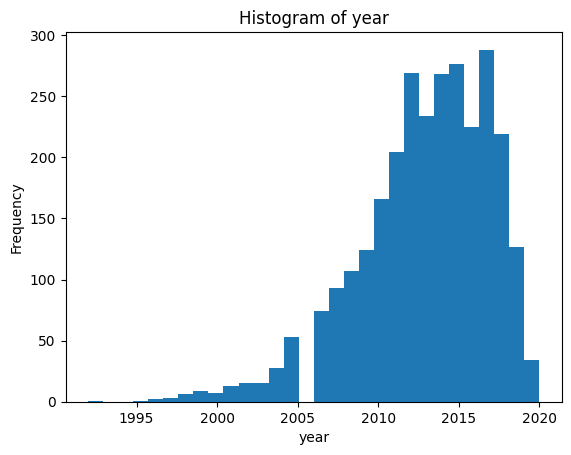

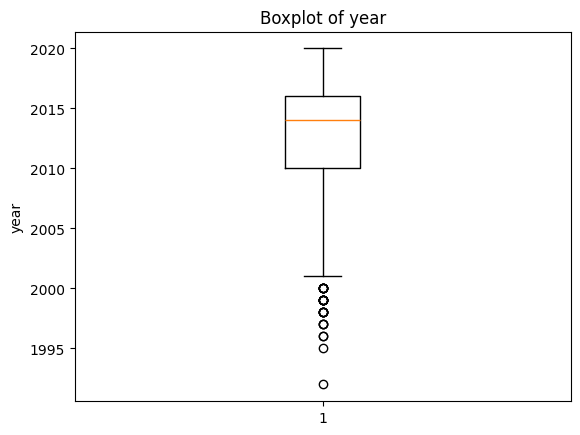

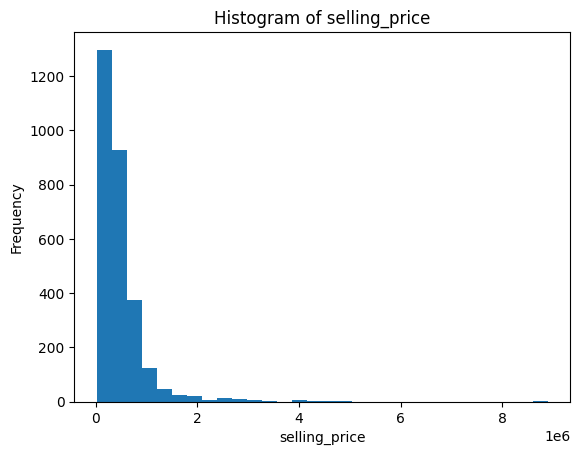

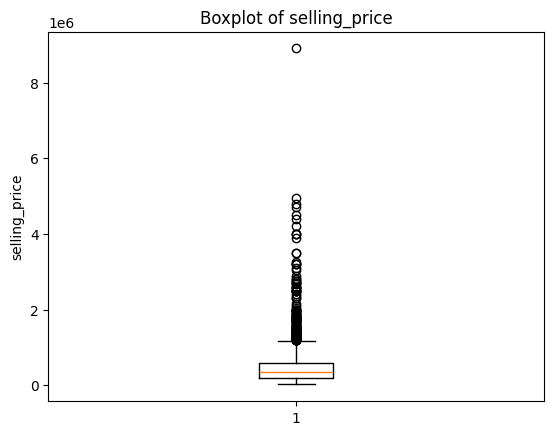

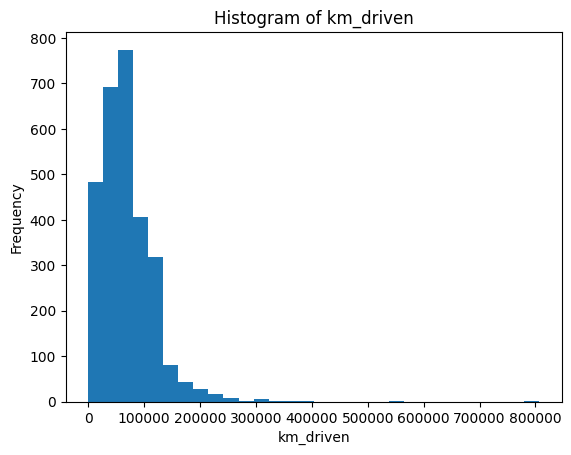

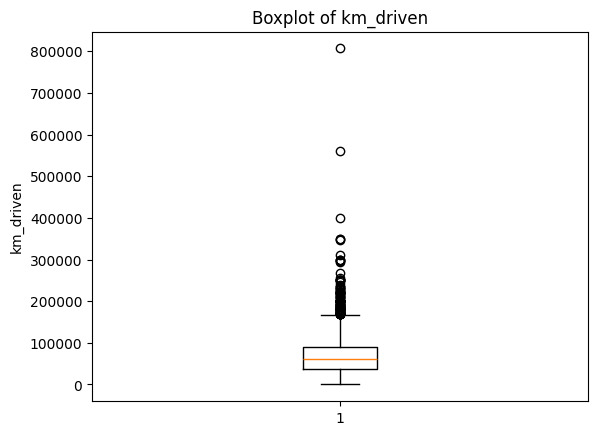

In [602]:
# Numeric columns relevant to outlier detection and LOF usage
numeric_cols = ["year", "selling_price", "km_driven"]
# Display distribution for each numeric column
for col in numeric_cols:
    plt.figure()
    plt.hist(DR[col].dropna(), bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    plt.figure()
    plt.boxplot(DR[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

From the charts, selling_price and km_driven are the most compelling candidates for LOF outlier detection. Both show heavy right‐skew (long tails) and a cluster of extreme values that stand out on the boxplots. Detecting anomalously high or low combinations of price and mileage is important in a used‐car context, e.g. an exceedingly high selling price for a high‐mileage vehicle may be suspicious.

We clearly observe that:
- selling_price has a significant spread with rare but very large values.
- km_driven similarly shows a dense cluster under 100,000 km but then stretches out to 800,000 km.

Including year in LOF is less critical because its range is fairly bounded (1992–2020), and older vehicles may not necessarily be "errors." They could be genuine vintage cars. 

Even though LOF doesn't operate on categorical features, we display their counts to see if there's any feature with extremely low count or not.

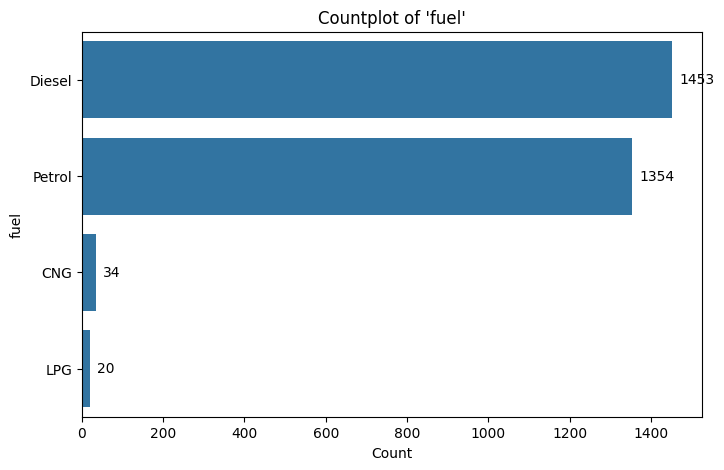

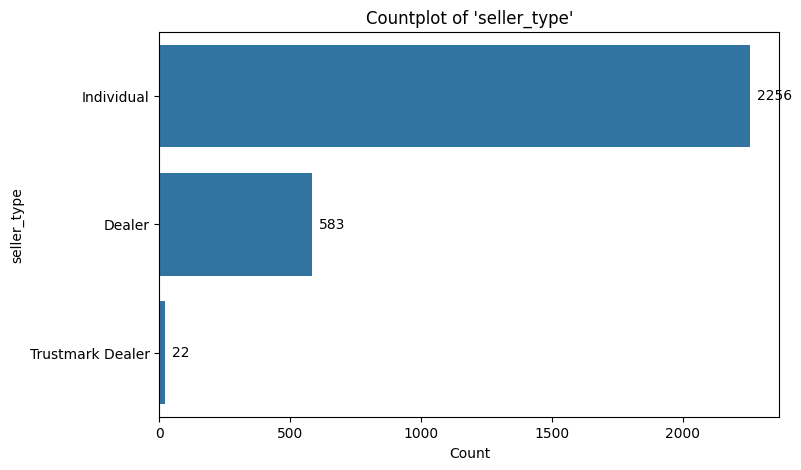

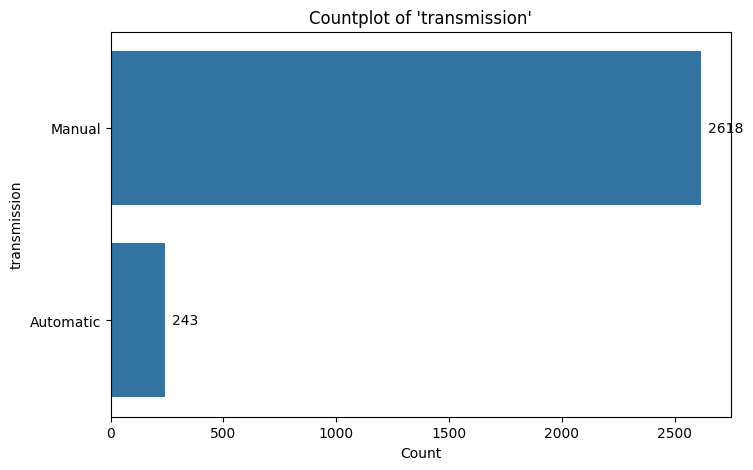

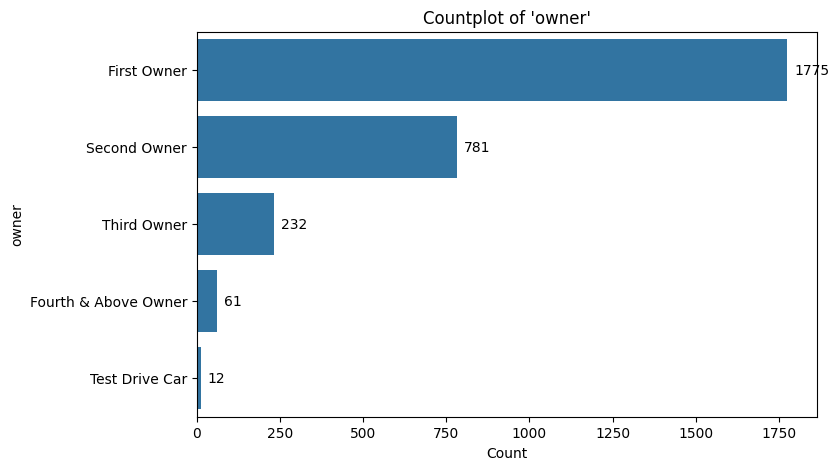

In [603]:
# Define categorical columns
categorical_cols = ["fuel", "seller_type", "transmission", "owner"]

# Plot countplots for each categorical col
for col in categorical_cols:
  plt.figure(figsize=(8, 5))
  graph = sns.countplot(y=DR[col], order=DR[col].value_counts().index)
  plt.title(f"Countplot of '{col}'")
  plt.xlabel("Count")
  plt.ylabel(col)
  for p in graph.patches:
    width = p.get_width()
    graph.annotate(f'{int(width)}', xy=(width, p.get_y() + p.get_height() / 2),
                  xytext=(5, 0), textcoords='offset points',
                  ha='left', va='center')
  plt.show()

**Handling Outliers**

**Numerical**

Before LOF, it makes sense to temporarily log-transform and standard-scale. The log transform addresses skew and large numerical ranges by compressing heavy tails, making the data more "normal", while standard scaling then centers (mean = 0) and normalizes (std = 1) those values, ensuring different features contribute more evenly to LOF.

We set n_neighbors to 30 for a moderate neighborhood size that balances local vs. global density estimation; it's large enough to mitigate issues like duplicates or small clusters but not so large that it blurs actual local anomalies.

It's important to note that when converting data into Z-scores, the original units and meaning are lost, since values are expressed solely as standard deviations from the mean. While this standardization is beneficial for distance-based calculations like LOF, it isn't intuitive when interpreting real-world data. For this reason, we visualize LOF scores using log-transformed units, making it easier to intuitively assess whether points are truly anomalous.

We will drop the outliers discovered by LOF to ensure that erroneous or extreme values do not skew model fitting. By removing these flagged rows, we preserve the typical relationships in the dataset, reducing the risk of overfitting to noise or undermining the model's validity. We don't treat these points as missing values, as we consider them genuinely invalid or unrepresentative rather than incomplete entries that can be reliably imputed.

**Categorical**

From the above charts, we note that certain categorical features have outliers. 

We will remove "Electric" from fuel and "Test Drive Car" from the "owner" column due to their extremely low frequencies: 1 and 14 instances, respectively. Such rare categories might skew the regression outcomes or introduce instability, as they do not represent meaningful segments. 

Conversely, we will keep "LPG" (20 instances), "CNG" (37 instances), and "Trustmark Dealer" (33 instances) despite their lower counts, as these still represent sufficient data points to contribute meaningfully without significantly biasing the model.

Just like the numerical outliers, we won't treat categorical outliers as missing values and impute them. We consider the categorical outlier points genuinely invalid.

In [604]:
def remove_outliers_and_categorical(d_in):
    """
    - Temporarily log-transforms 'selling_price' and 'km_driven' to handle skew
    - Standard-scales those logged values
    - Uses LOF to detect numeric outliers
    - Plots outliers vs. inliers in log space for visualization
    - Keeps only inliers (predictions == 1)
    - Removes rows where fuel == 'Electric' or owner == 'Test Drive Car'
    - Returns the cleaned dataframe
    """
    df_lof = d_in.copy()
    # Log-transform 'selling_price' and 'km_driven' to handle skew
    df_lof["log_selling_price"] = np.log1p(df_lof["selling_price"])
    df_lof["log_km_driven"] = np.log1p(df_lof["km_driven"])
    data_logged = df_lof[["log_selling_price", "log_km_driven"]]

    # Standard scale the log-transformed features to put them
    # in proportional, similar units for distance calculation
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_logged)

    # Prepare LOF class, fit, and predict
    lof = LocalOutlierFactor(n_neighbors=30)
    predictions = lof.fit_predict(data_scaled) 

    # Count & display numeric outliers
    outliers = df_lof[predictions == -1]
    n_outliers = len(outliers)
    print(f"Number of outliers detected (bivariate, log+scaled, auto contamination): {n_outliers}")
    if n_outliers > 0:
        print("Sample outliers:")
        display(outliers.head(5))
    else:
        print("No outliers flagged with these LOF settings.")

    # Results
    plt.figure(figsize=(8, 5))
    # For interpretability, we plot the log-transformed values
    inliers_logged = data_logged[predictions == 1]
    outliers_logged = data_logged[predictions == -1]
    plt.scatter(inliers_logged["log_km_driven"], inliers_logged["log_selling_price"],
                label="Inliers (log-space)", alpha=0.5)
    plt.scatter(outliers_logged["log_km_driven"], outliers_logged["log_selling_price"],
                color="red", label="Outliers (log-space)", marker="x", s=80)
    plt.title("LOF Outliers in Log Space")
    plt.xlabel("log_km_driven")
    plt.ylabel("log_selling_price")
    plt.legend()
    plt.show()

    print("Removing numerical outliers")
    print()
    print(f"Shape before removing numerical outliers: {df_lof.shape}")
    print()
    df_lof = df_lof[predictions == 1].copy()
    print(f"Shape after removing numerical outliers: {df_lof.shape}")
    print()

    print("Removing one-hot columns for categorical outliers")
    print()
    print(f"Shape before removing one-hot columns: {df_lof.shape}")
    print()
    one_hot_cols_to_drop = ["fuel_Electric", "owner_Test Drive Car"]
    df_lof.drop(columns=one_hot_cols_to_drop, inplace=True, errors="ignore")
    print("Remaining columns:", df_lof.columns)
    print()
    print(f"Shape after removing one-hot columns: {df_lof.shape}")
    print()

    # Drop the log columns from the returned dataframe
    print("Removing log transformed features for LOF")
    print()
    df_lof.drop(columns=["log_selling_price", "log_km_driven"], inplace=True, errors="ignore")
    print("Final columns:", df_lof.columns)
    print()
    return df_lof

### **Section D: Exploring Linear Regression**

The assignment instructions suggest exploring linear regression; however, linear regression itself is not directly "explorable." Linear regression is a statistical method used to model the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data. It estimates the coefficients that minimize the difference between predicted values and actual observations. Instead of directly exploring linear regression, we will apply this method later to train a model on our completed dataset, using the default LinearRegression implementation from scikit-learn.

### **Section E: Feature Engineering**

**New Features**

Two especially useful engineered features that we can create are car_age (current_year - year) and km_per_year (km_driven / car_age). car_age captures the idea that older vehicles typically depreciate more, so it often correlates strongly with selling price. km_per_year shows how heavily the car was driven each year, which goes beyond total mileage by accounting for how long the car has been on the road. Both features use simple arithmetic with existing columns and can help a linear model relate mileage, age, and price.

In [605]:
def add_aggregated_features(df_in, current_year=2025):
  """
  Adds two new features:
  - car_age = current_year - year
  - km_per_year = km_driven/car_age
  Logs target variable, selling_price
  Returns a copy of the dataframe with the new columns
  """
  df_out = df_in.copy()
  # car_age
  df_out["car_age"] = current_year - df_out["year"]
  # km_per_year, avoiding division by zero
  df_out["km_per_year"] = np.where(
    df_out["car_age"] == 0,
    df_out["km_driven"],
    df_out["km_driven"] / df_out["car_age"]
  )
  return df_out

### **Section F: Empirical Study**

**Creating the 4 DR variants**

Creating DR1: No outlier removal, no new features.
Created DR1
Creating DR2: No outlier removal, but WITH new features.
Created DR2
Creating DR3: Outlier removal (LOF + categorical), no new features.
Number of outliers detected (bivariate, log+scaled, auto contamination): 40
Sample outliers:


,year,selling_price,km_driven,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,log_selling_price,log_km_driven
2118,2011,75000,9528,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,11.225257,9.162095
3898,2010,90000,300000,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,11.407576,12.611541
3081,2007,100000,170000,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False,11.512935,12.043560
69,2010,280000,350000,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,12.542548,12.765691
1496,2011,149000,10000,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,11.911708,9.210440


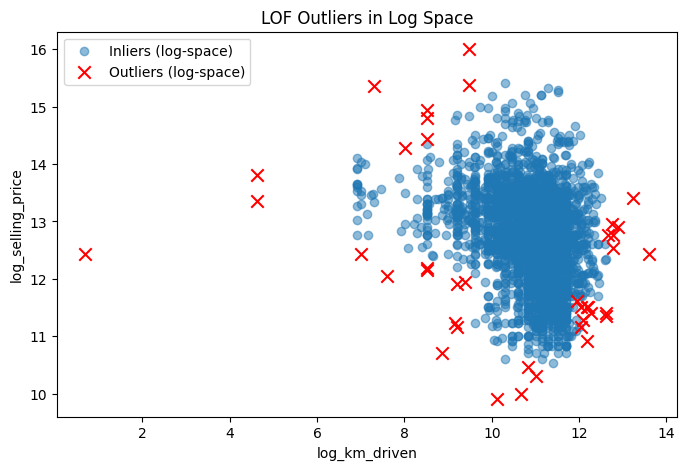

Removing numerical outliers

Shape before removing numerical outliers: (2861, 20)

Shape after removing numerical outliers: (2821, 20)

Removing one-hot columns for categorical outliers

Shape before removing one-hot columns: (2821, 20)

Remaining columns: Index(['year', 'selling_price', 'km_driven', 'fuel_CNG', 'fuel_Diesel',
       'fuel_LPG', 'fuel_Petrol', 'seller_type_Dealer',
       'seller_type_Individual', 'seller_type_Trustmark Dealer',
       'transmission_Automatic', 'transmission_Manual', 'owner_First Owner',
       'owner_Fourth & Above Owner', 'owner_Second Owner', 'owner_Third Owner',
       'log_selling_price', 'log_km_driven'],
      dtype='object')

Shape after removing one-hot columns: (2821, 18)

Removing log transformed features for LOF

Final columns: Index(['year', 'selling_price', 'km_driven', 'fuel_CNG', 'fuel_Diesel',
       'fuel_LPG', 'fuel_Petrol', 'seller_type_Dealer',
       'seller_type_Individual', 'seller_type_Trustmark Dealer',
       'transmission_Au

,year,selling_price,km_driven,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,log_selling_price,log_km_driven
2118,2011,75000,9528,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,11.225257,9.162095
3898,2010,90000,300000,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,11.407576,12.611541
3081,2007,100000,170000,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False,11.512935,12.043560
69,2010,280000,350000,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,12.542548,12.765691
1496,2011,149000,10000,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,11.911708,9.210440


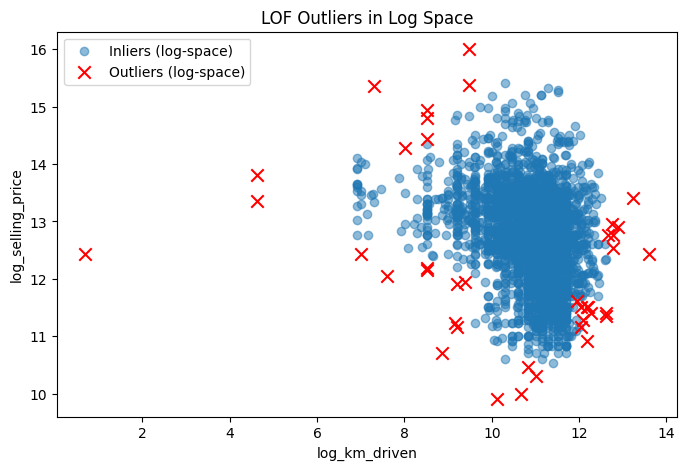

Removing numerical outliers

Shape before removing numerical outliers: (2861, 20)

Shape after removing numerical outliers: (2821, 20)

Removing one-hot columns for categorical outliers

Shape before removing one-hot columns: (2821, 20)

Remaining columns: Index(['year', 'selling_price', 'km_driven', 'fuel_CNG', 'fuel_Diesel',
       'fuel_LPG', 'fuel_Petrol', 'seller_type_Dealer',
       'seller_type_Individual', 'seller_type_Trustmark Dealer',
       'transmission_Automatic', 'transmission_Manual', 'owner_First Owner',
       'owner_Fourth & Above Owner', 'owner_Second Owner', 'owner_Third Owner',
       'log_selling_price', 'log_km_driven'],
      dtype='object')

Shape after removing one-hot columns: (2821, 18)

Removing log transformed features for LOF

Final columns: Index(['year', 'selling_price', 'km_driven', 'fuel_CNG', 'fuel_Diesel',
       'fuel_LPG', 'fuel_Petrol', 'seller_type_Dealer',
       'seller_type_Individual', 'seller_type_Trustmark Dealer',
       'transmission_Au

In [606]:
# Define columns that we're dropping from DR and DT
# These are the columns that are extra from one-hot encoding
cols_to_drop = ["fuel", "seller_type", "transmission", "owner"]

print("Creating DR1: No outlier removal, no new features.")
DR1 = DR.copy()
DR1.drop(columns=cols_to_drop, inplace=True, errors="ignore")
print("Created DR1")
print("="*50)

print("Creating DR2: No outlier removal, but WITH new features.")
DR2 = DR.copy()
DR2.drop(columns=cols_to_drop, inplace=True, errors="ignore")
DR2 = add_aggregated_features(DR2)
print("Created DR2")
print("="*50)

print("Creating DR3: Outlier removal (LOF + categorical), no new features.")
DR3 = DR.copy()
DR3.drop(columns=cols_to_drop, inplace=True, errors="ignore")
DR3 = remove_outliers_and_categorical(DR3)
print("Created DR3")
print("="*50)

print("Creating DR4: Outlier removal + new features.")
DR4 = DR.copy()
DR4.drop(columns=cols_to_drop, inplace=True, errors="ignore")
DR4 = remove_outliers_and_categorical(DR4)
DR4 = add_aggregated_features(DR4)
print("Created DR4")
print("="*50)

# Also drop these columns from DT for consistency
DT.drop(columns=cols_to_drop, inplace=True, errors="ignore")

print("Shapes after dropping columns:")
print("DR1 shape:", DR1.shape)
print("DR2 shape:", DR2.shape)
print("DR3 shape:", DR3.shape)
print("DR4 shape:", DR4.shape)
print("DT shape:", DT.shape)


**Running 4-Fold Cross Validation**

In [607]:
def cross_validate_variant(df_variant, cv_splits=4):
  """
  - Splits df_variant into X (features) and y (target)
  - Runs 4-fold cross validation
  - Returns average MSE and average R^2
  """
  # Separate features and target
  X = df_variant.drop(columns=["selling_price"])
  y = df_variant["selling_price"]
  
  # Setup up the Linear regression model
  model = LinearRegression()
  
  # Cross-validation for negative MSE (but we convert to positive)
  mse_scores = cross_val_score(
    model,
    X, y,
    cv=cv_splits,
    scoring="neg_mean_squared_error"
  )
  
  # Cross-validation for R^2
  r2_scores = cross_val_score(
    model,
    X, y,
    cv=cv_splits,
    scoring="r2"
  )
  
  # Calculate average metrics
  mean_mse = -mse_scores.mean()
  mean_r2  = r2_scores.mean()
  return mean_mse, mean_r2

# Evaluate each variant
variants = [
  ("DR1 (Baseline)", DR1),
  ("DR2 (Features)", DR2),
  ("DR3 (Outliers Removed)", DR3),
  ("DR4 (Outliers Removed+Features)", DR4)
]
results_dict = {}
for name, dfv in variants:
  mse_val, r2_val = cross_validate_variant(dfv, cv_splits=4)
  results_dict[name] = {"mean_MSE": mse_val, "mean_R2": r2_val}

**Using The Best System**

In [608]:
# Convert results dict into a dataframe for clear comparison
results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df = results_df.rename(columns={
    "mean_MSE": "Mean MSE",
    "mean_R2": "Mean R^2"
})
# Sort table by Mean R^2
results_df_sorted = results_df.sort_values(by="Mean R^2", ascending=False)
display(results_df_sorted.round(3))

,Mean MSE,Mean R^2
DR4 (Outliers Removed+Features),1.065331e+11,0.474
DR3 (Outliers Removed),1.065800e+11,0.474
DR1 (Baseline),1.350228e+11,0.451
DR2 (Features),1.353167e+11,0.450


The results now show that DR4 (Outliers Removed + Features) has the lowest mean MSE (1.065331e+11) and ties with DR3 on mean R^2 (0.474). This suggests that removing outliers and adding features (such as car_age and km_per_year) offers a slight improvement over simply removing outliers or using the baseline approach. Because DR4 still edges out the other variants in cross‐validation, it makes sense to select it for final predictions on the test set. By combining outlier removal and feature engineering, DR4 achieves both lower error and higher explanatory power compared to the baseline or individual interventions alone, which should improve its generalization to new data.

**Testing on DT**

In [ ]:
# Prepare DR4 for final training
X_train = DR4.drop(columns=["selling_price"])
y_train = DR4["selling_price"]

# Train a final linear regression model on DR4
final_model = LinearRegression()
final_model.fit(X_train, y_train)

# Prepare the test set the same way we prepared DR4 (minus outlier removal)
one_hot_cols_to_drop = ["fuel_Electric", "owner_Test Drive Car"]
DT.drop(columns=one_hot_cols_to_drop, inplace=True, errors="ignore")

# Add aggreated features (including log scaling of target variable)
DT_test = add_aggregated_features(DT)

# Split the test set into features and target 
X_test = DT_test.drop(columns=["selling_price"])
y_test = DT_test["selling_price"]

# Predict on the test set
y_pred = final_model.predict(X_test)

# Calculate test set metrics
test_mse = mean_squared_error(y_test, y_pred)
test_r2  = r2_score(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R^2:  {test_r2:.4f}")

Test MSE: 196729802656.6460
Test R^2:  0.3893


### **Section G: Results Analysis**

**a) Analysis of Obtained Results and Improvement**

After experimenting with various data transformations, including outlier removal and feature aggregation, DR4 (Outliers Removed + Features) tended to show the strongest performance during cross validation (lowest MSE and relatively high R^2). However, once we applied the final model to the unseen test set, we observed a test MSE of approximately 1.97*10^9 and an R^2 of about 0.389. Compared to cross validation, this represents a drop in R^2, suggesting that while DR4 does benefit from outlier removal and feature engineering, the model's predictive capacity on truly new data is weaker than expected based on cross-validation alone.

Such a generalization gap (a discrepancy between cross validation metrics and test metrics) often indicates that certain relationships in the training data (even after outlier removal) do not fully hold in the unseen test set.


**b) Impact of Outlier Detection and Feature Aggregation**

Removing outliers can reduce the influence of extreme values that distort linear regression coefficients. In the training phase, it often yields better parameter estimates and less sensitivity to large, aberrant points. In cross-validation, this led to improved metrics. However, because we typically do not remove outliers from the test set, any unusual points there can still hurt real-world performance if they differ substantially.

Introducing aggregated features (e.g. car_age, km_per_year) can capture important relationships between mileage, age, and price. These derived features often lead to more interpretable patterns and help the model explain variance that raw columns might miss. Especially in domains like car pricing, capturing depreciation via car_age and usage via km_per_year can be crucial for predictive accuracy.

**c) Comparing Test-Set Results to Cross-Validation Results**

While cross-validation indicated that DR4 achieved both a lower MSE and higher R^2 relative to other variants, the test-set R^2 of approx. 0.389 is noticeably lower than the cross validation estimate of approx. 0.474.
This difference highlights that the model may be overfitting the training data (despite outlier removal) or that the test set contains different patterns not well captured by the training set.

**Additional Considerations**

Even after outlier removal and feature engineering, some original columns might still skew the linear relationship. Features that either have very few samples in certain categories or contain numeric values that are far outside the typical range can disproportionately impact the model, potentially distorting its linear relationships. Removing or adjusting those columns, or applying a more robust modeling technique (e.g. Ridge, Lasso), can sometimes further improve real-world performance. Notably, ensuring that any features which strongly violate the linear assumption are either transformed or dropped can help reduce noise and improve the model's generalization. 

In the case of our model, km_driven shows a wide range, extending up to around 800,000 km, which heavily pulls down the regression line. The scatter plot makes it clear that extremely high mileage points are not well described by a simple linear slope. By removing or transforming (e.g. log-scaling) the km_driven feature, or even adopting a robust or regularized regression, we may achieve a better fit and improved performance on new data.

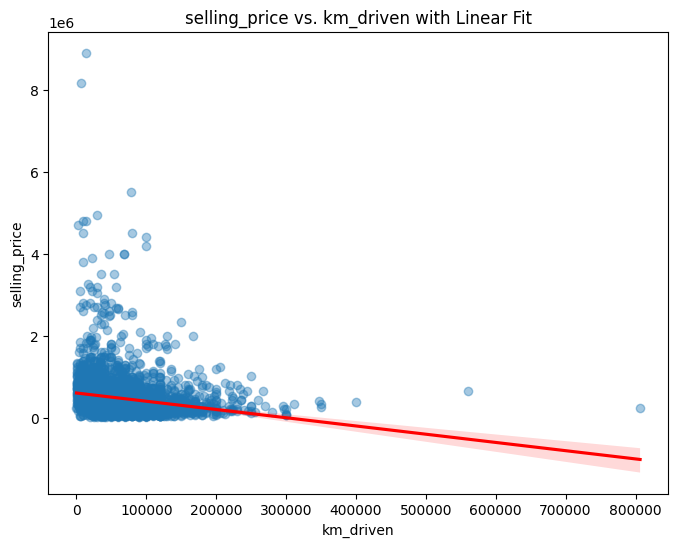

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(
    x="km_driven",
    y="selling_price",
    data=df, 
    scatter_kws={"alpha": 0.4},
    line_kws={"color": "red"} 
)
plt.title("selling_price vs. km_driven with Linear Fit")
plt.xlabel("km_driven")
plt.ylabel("selling_price")
plt.show()

### **Conclusion**

In this project, we cleaned and transformed a dataset of car listings, focusing on outlier detection, feature engineering, and model training. Data validation confirmed that the dataset's columns matched expected types and ranges, and exact duplicates were removed to avoid redundancy. After one-hot encoding the categorical features, LOF was used to detect extreme numeric outliers, and rare categories were excluded to reduce data sparsity. New features were introduced to capture age and yearly mileage, and transformations were explored to address heavy skew in key columns.

Multiple dataset variants were created and evaluated using linear regression. The approach that combined outlier removal and feature engineering showed stronger performance during cross-validation, producing lower error and a higher measure of explanatory power than the baseline or simpler alternatives. However, the final evaluation on unseen data revealed a decline in model accuracy, indicating that certain patterns learned during training did not generalize fully. Despite this gap, the improvements gained from targeted outlier handling and feature design clearly highlight the benefits of careful data preprocessing for linear regression.

Further refinement could involve transforming or removing especially high-leverage features, such as extreme mileage, or adopting more robust or regularized regression methods to mitigate overfitting. Monitoring residuals and validating model assumptions would also help ensure that linear relationships remain meaningful in practice. This project demonstrates how strategic cleaning and feature engineering can enhance regression performance.

### **References**

[1] https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho

[2] https://www.algosome.com/articles/dummy-variable-trap-regression.html